In [1]:
import torch
import torch.optim as optim
import numpy as np
import scanpy as sc
import scvelo as scv
import sys, os
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
from model import NETWORK  # Ensure that model.py is saved in the same directory
from dataloaders import * # Ensure that dataloaders.py is saved in the same directory
from utils import *
from sklearn.manifold import Isomap
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import dijkstra
import gc
import pandas as pd
import seaborn as sns

In [2]:
# Setup configuration
latent_dim = 64  # Latent dimension size, can be adjusted
hidden_dim = 512  # Hidden dimension size for the encoder and decoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

n_components = 100
n_knn_search = 10
dataset_name = "gastrulation_erythroid"
cell_type_key = "celltype"
model_name = "VeloFormer"

num_genes = 2000
nhead = 1 #original: 1
embedding_dim = 128*nhead# original: 128
num_encoder_layers = 1 #original: 1
num_bins = 50
batch_size = 128  # Batch size for training
epochs = 10  # Number of epochs for training
learning_rate = 1e-4  # Learning rate for the optimizer
lambda1 = 1e-1  # Weight for heuristic loss
lambda2 = 1 # Weight for discrepancy loss
K = 11  # Number of neighbors for heuristic loss

# Load data
adata = sc.read_h5ad("gastrulation_processed.h5ad")


# Initialize model, optimizer, and loss function
model = NETWORK(input_dim=adata.shape[1]*2, latent_dim=latent_dim, 
                hidden_dim=hidden_dim, emb_dim = embedding_dim,
                nhead=nhead, num_encoder_layers=num_encoder_layers,
                num_genes=num_genes, num_bins=num_bins).to(device)
                
model.load_state_dict(torch.load('model.pth'))

# Ensure to call model.eval() if you're loading the model for inference to set the dropout and batch normalization layers to evaluation mode
model.eval()


NETWORK(
  (embeddings): Embedding(4000, 128)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=

In [3]:
_, _, full_data_loader = setup_dataloaders_binning(adata, 
                                                    batch_size=batch_size, 
                                                    num_genes=num_genes, 
                                                    num_bins=num_bins)

# Initialize empty layers in adata for storing results
adata.layers["velocity_u"] = np.zeros_like(adata.layers["Mu"], dtype=np.float32)
adata.layers["velocity"] = np.zeros_like(adata.layers["Ms"], dtype=np.float32)
adata.obsm["pred"] = np.zeros((adata.shape[0], adata.shape[1] * 2), dtype=np.float32)
adata.obsm["cell_embeddings"] = np.zeros((adata.shape[0], adata.shape[1] * 2), dtype=np.float32)
adata.layers["pp"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.layers["nn"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.layers["pn"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.layers["np"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
model.eval()
with torch.no_grad():
    for batch_idx, (tokens, data, batch_indices) in enumerate(full_data_loader):
        print(f"Batch {batch_idx+1}/{len(full_data_loader)}")
        tokens = tokens.to(device)
        data = data.to(device)
        out_dic = model(tokens, data)

        # Store results and convert to numpy inside the loop to reduce peak memory usage
        adata.layers["velocity_u"][batch_indices] = out_dic["v_u"].detach().cpu().numpy()
        adata.layers["velocity"][batch_indices] = out_dic["v_s"].detach().cpu().numpy()
        adata.obsm["pred"][batch_indices] = out_dic["pred"].detach().cpu().numpy()
        adata.obsm["cell_embeddings"][batch_indices] = out_dic["cell_embeddings"].detach().cpu().numpy()
        adata.layers["pp"][batch_indices] = out_dic["pp"].cpu().numpy()
        adata.layers["nn"][batch_indices] = out_dic["nn"].cpu().numpy()
        adata.layers["pn"][batch_indices] = out_dic["pn"].cpu().numpy()
        adata.layers["np"][batch_indices] = out_dic["np"].cpu().numpy()

        # Explicit memory cleanup
        del tokens, data, out_dic
        gc.collect()
        torch.cuda.empty_cache()  # If using CUDA

Batch 1/698
Batch 2/698
Batch 3/698
Batch 4/698
Batch 5/698
Batch 6/698
Batch 7/698
Batch 8/698
Batch 9/698
Batch 10/698
Batch 11/698
Batch 12/698
Batch 13/698
Batch 14/698
Batch 15/698
Batch 16/698
Batch 17/698
Batch 18/698
Batch 19/698
Batch 20/698
Batch 21/698
Batch 22/698
Batch 23/698
Batch 24/698
Batch 25/698
Batch 26/698
Batch 27/698
Batch 28/698
Batch 29/698
Batch 30/698
Batch 31/698
Batch 32/698
Batch 33/698
Batch 34/698
Batch 35/698
Batch 36/698
Batch 37/698
Batch 38/698
Batch 39/698
Batch 40/698
Batch 41/698
Batch 42/698
Batch 43/698
Batch 44/698
Batch 45/698
Batch 46/698
Batch 47/698
Batch 48/698
Batch 49/698
Batch 50/698
Batch 51/698
Batch 52/698
Batch 53/698
Batch 54/698
Batch 55/698
Batch 56/698
Batch 57/698
Batch 58/698
Batch 59/698
Batch 60/698
Batch 61/698
Batch 62/698
Batch 63/698
Batch 64/698
Batch 65/698
Batch 66/698
Batch 67/698
Batch 68/698
Batch 69/698
Batch 70/698
Batch 71/698
Batch 72/698
Batch 73/698
Batch 74/698
Batch 75/698
Batch 76/698
Batch 77/698
Batch 78

In [4]:
#adata.write_h5ad("final_adata.h5ad")

In [5]:
#adata = sc.read_h5ad("res_gastr.h5ad")

In [4]:
np.isnan(adata.layers["velocity_u"]).sum()

0

In [5]:
np.isnan(adata.layers["velocity"]).sum()

0

In [6]:
adata.obsm["MuMs"] = np.concatenate([adata.layers["Mu"], adata.layers["Ms"]], axis=1)
adata.obsm["velocity"] = np.concatenate([adata.layers["velocity_u"], adata.layers["velocity"]], axis=1)

In [ ]:
adata.layers["velocity_u"]

In [20]:
adata.layers["velocity_u"][adata.obs["batch"] == "gastrulation"] *= -1
adata.layers["velocity"][adata.obs["batch"] == "gastrulation"] *= -1

In [13]:
adata.layers["velocity_u"][adata.obs["batch"] == "pancreas"] *= -1
adata.layers["velocity"][adata.obs["batch"] == "pancreas"] *= -1

In [11]:
#adata.layers["velocity_u"] *= -1
#adata.layers["velocity"] *= -1

In [ ]:
sc.pp.neighbors(adata)
#sc.tl.umap(adata)
scv.tl.velocity_graph(adata, n_jobs=8)
#scv.tl.velocity_confidence(adata)
#scv.tl.velocity_pseudotime(adata)
#keys = ["celltype", "velocity_confidence", "velocity_length", "velocity_pseudotime"]
keys = ["celltype"]
sc.pl.umap(adata, color=keys)
scv.pl.velocity_embedding_stream(adata, color=keys, basis="umap")

computing velocity graph (using 8/24 cores)


In [ ]:
keys=""

In [5]:
adata

AnnData object with n_obs × n_vars = 89267 × 2000
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'numerical_index'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'indices', 'log1p'
    obsm: 'X_pca', 'X_umap', 'cell_embeddings', 'pred'
    layers: 'Ms', 'Mu', 'counts_spliced', 'counts_unspliced', 'nn', 'np', 'pn', 'pp', 'spliced', 'unspliced', 'velocity', 'velocity_u'

In [2]:
adata = sc.read_h5ad("gastrulation_velocity.h5ad")


computing velocity embedding
    finished (0:00:12) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


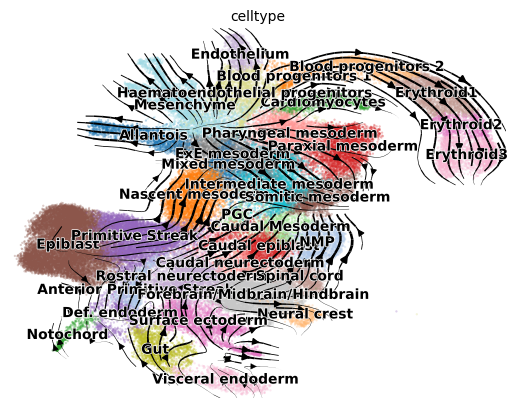

In [3]:
scv.pl.velocity_embedding_stream(adata, color="celltype", basis="umap")

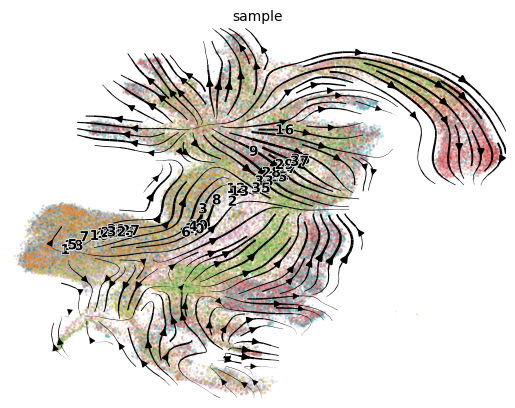

In [19]:
scv.pl.velocity_embedding_stream(adata, color="sample", basis="umap")

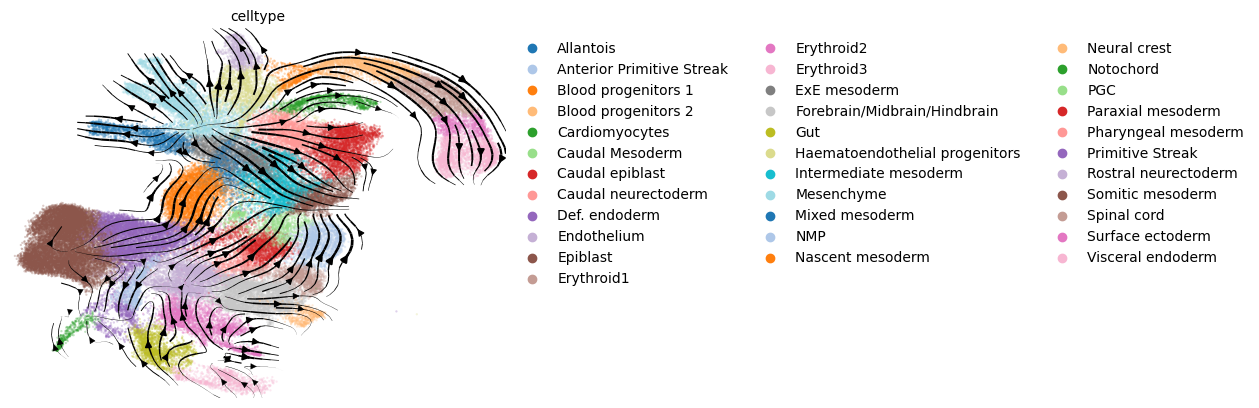

In [5]:
scv.pl.velocity_embedding_stream(adata, color="celltype", basis="umap", legend_loc="upper right")

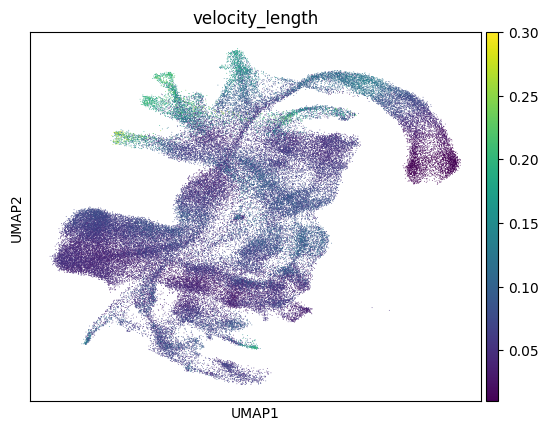

In [9]:
sc.pl.umap(adata, color="velocity_length")

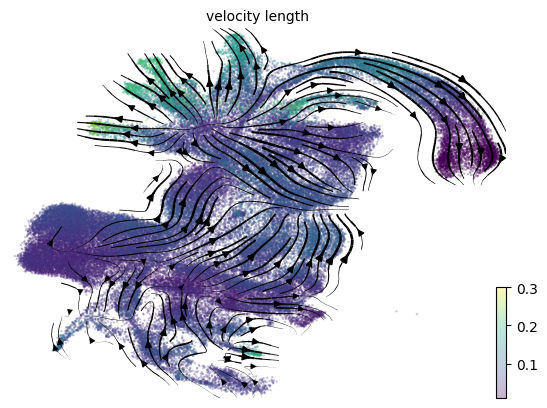

In [8]:
scv.pl.velocity_embedding_stream(adata, color="velocity_length", basis="umap", legend_loc="on data")

In [ ]:
sc.pp.neighbors(adata,use_rep="velocity")
sc.tl.umap(adata)
keys = [cell_type_key, "stage"]
sc.pl.umap(adata, color=keys)

In [ ]:
sc.pp.neighbors(adata, use_rep="cell_embeddings")
sc.tl.umap(adata)
sc.pl.umap(adata, color=[cell_type_key, "stage"])

In [ ]:
scv.tl.rank_velocity_genes(adata, groupby=cell_type_key)
pd.DataFrame(adata.uns["rank_velocity_genes"]["names"])

In [3]:
adata = sc.read_h5ad("gastrulation_velocity.h5ad")

In [4]:
gene_names = ["Actb", "Hba-x", "Rap1b", "Gnas", "Rbfox3", "Rpl18a"]

In [12]:
cell_types_to_select = ["Blood progenitors 1", "Blood progenitors 2", "Erythroid1", "Erythroid2", "Erythroid3"]  # Replace with your desired cell types
adata_tmp = adata[adata.obs["celltype"].isin(cell_types_to_select)].copy()

In [17]:
adata_tmp = color_keys(adata_tmp, "sample")

Plot saved to plots/plot1.png


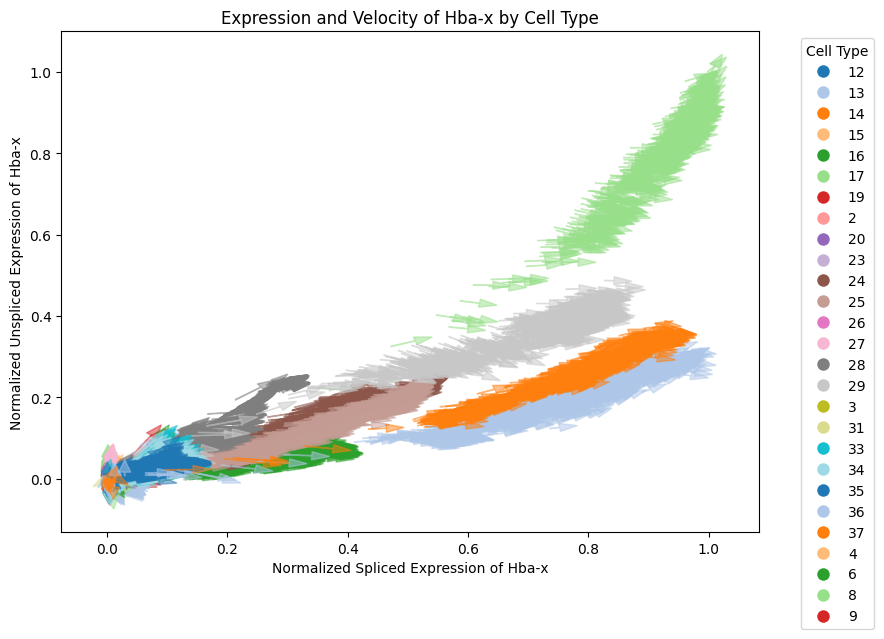

In [18]:
plot_phase_plane(adata_tmp, "Hba-x", "dataset_name", 11, 
            u_scale=0.1, s_scale=0.1, cell_type_key="sample",
            save_path="plots/plot1.png")

Plot saved to plots/plot1.png


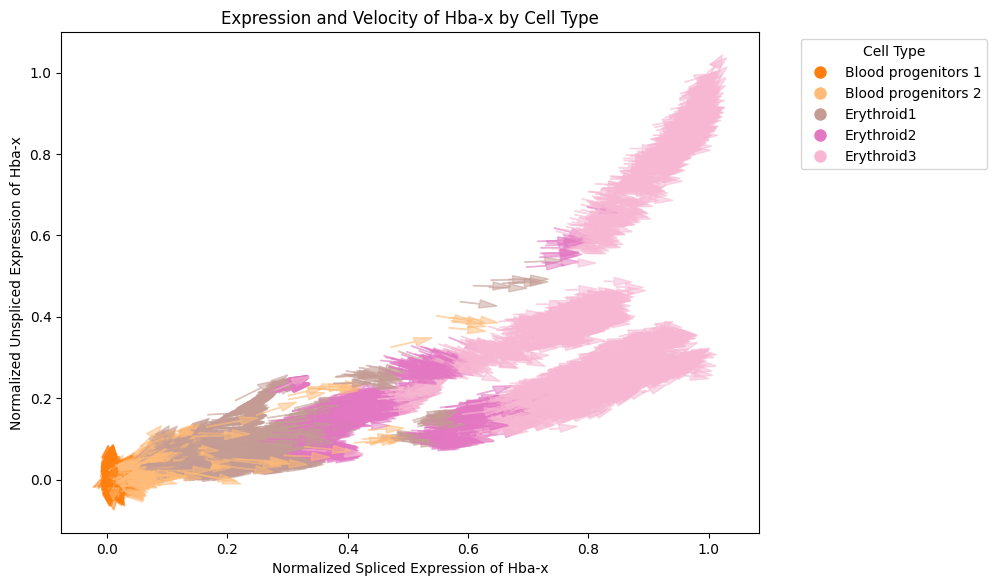

In [13]:
plot_phase_plane(adata_tmp, "Hba-x", "dataset_name", 11, 
            u_scale=0.1, s_scale=0.1, cell_type_key="celltype",
            save_path="plots/plot1.png")

Plot saved to plots/plot1.png


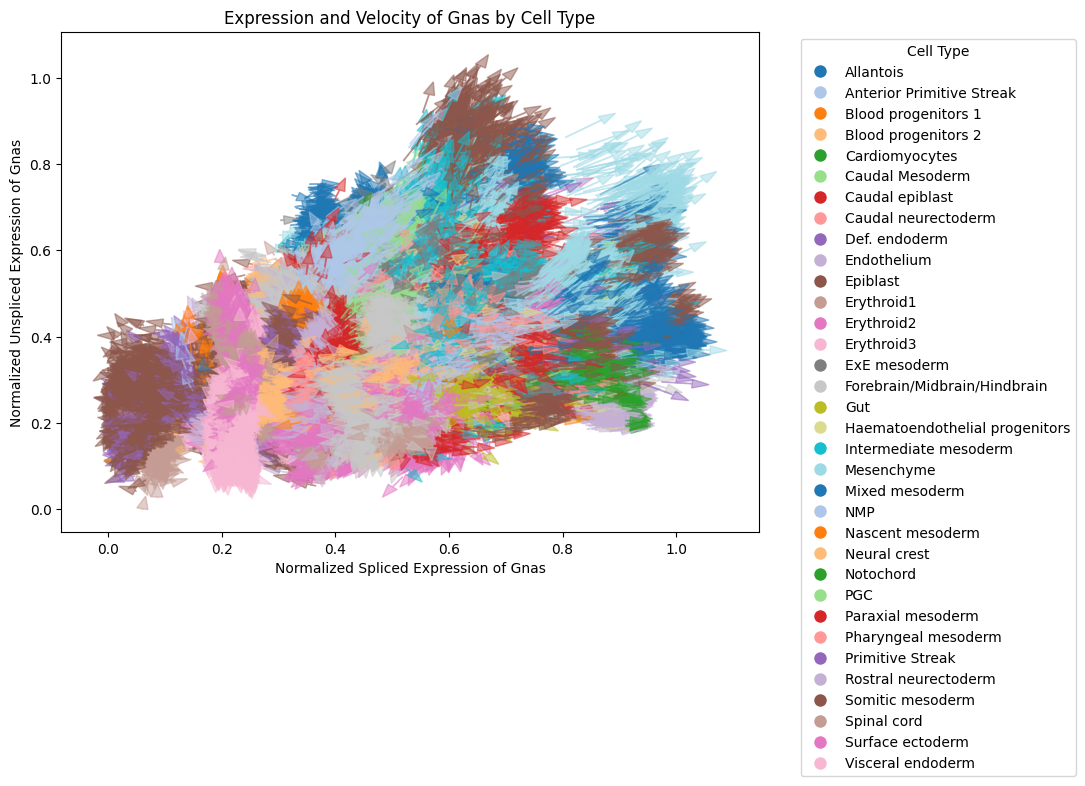

In [10]:
plot_phase_plane(adata, "Gnas", "dataset_name", 11, 
            u_scale=0.1, s_scale=0.1, cell_type_key="celltype",
            save_path="plots/plot1.png")

In [ ]:
for stage in adata.obs["stage"].unique():
    adata_tmp = adata[adata.obs["stage"] == stage].copy()
    sc.pp.neighbors(adata_tmp)
    sc.tl.umap(adata_tmp)
    scv.pl.velocity_embedding_stream(adata_tmp, color=[cell_type_key], basis="umap")
    for gene_name in gene_names:
        plot_phase_plane(adata_tmp, gene_name, dataset_name, 11, 
                    u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key,
                    save_path="plots/plot1.png")

In [ ]:
for gene_name in gene_names:
    plot_phase_plane(adata, gene_name, dataset_name, 11, 
                    u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key,
                    save_path="plots/plot1.png")
    plot_phase_plane(adata, gene_name, dataset_name, 11, 
                    u_scale=0.1, s_scale=0.1, cell_type_key="stage",
                    save_path="plots/plot1.png")
    

In [ ]:
scv.datasets.